In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

from athena.active import ActiveSubspaces
from athena.nll import NonlinearLevelSet
from athena.utils import Normalizer, local_linear_gradients

from helper_functions import *

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def plot_sufficient_summary2(nll,
                            inputs,
                            outputs,
                            filename=None,
                            figsize=(10, 8),
                            title=''):
        """
        Plot the sufficient summary.

        :param torch.Tensor inputs: DoubleTensor n_samples-by-n_params
            containing the points in the full input space.
        :param numpy.ndarray outputs: array n_samples-by-1 containing the
            corresponding function evaluations.
        :param str filename: if specified, the plot is saved at `filename`.
        :param tuple(int,int) figsize: tuple in inches defining the figure
            size. Defaults to (10, 8).
        :param str title: title of the plot.
        :raises: ValueError

        .. warning::
            Plot only available for active dimensions up to 1.
        """
        plt.figure(figsize=figsize)
        plt.title(title)

        if nll.active_dim == 1:
            reduced_inputs = nll.forward(inputs)[:, 0]
            plt.plot(reduced_inputs.detach().numpy(), outputs, 'bo')
            plt.xlabel('Reduced input (z1)')
            plt.ylabel('Output')
        else:
            raise ValueError(
                'Sufficient summary plots cannot be made in more than 1 ' \
                'dimension.'
            )

        plt.grid(linestyle='dotted')

        if filename:
            plt.savefig(filename)
        else:
            plt.show()

In [3]:
np.random.seed(50)

# global parameters
n_train = 2000
n_params = 8
# 8th variable is dummy variable

example = 5

In [4]:
# Uniformly distributed inputs
lb = np.array([30, 0.005, 0.002, 1000, 90000, 290, 340, 0]) # lower bounds
ub = np.array([60, 0.020, 0.010, 5000, 110000, 296, 360, 1]) # upper bounds

def inputs_uniform(n_samples, n_pars, lb,  ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(lb.shape[0])]).T)

In [5]:
### Training data
x_raw = inputs_uniform(n_train, n_params, lb, ub)
nor = Normalizer(lb, ub)
x_np = nor.fit_transform(x_raw)

In [6]:
### Validation data
n_valid = 2000
x_valid_raw = inputs_uniform(n_valid, n_params, lb, ub)
x_valid = nor.fit_transform(x_valid_raw)

In [7]:
# Define the output of interest and compute the gradients
f = test_func(x_np, example, normalizer=nor)[0]
df_np = test_func(x_np, example, normalizer=nor)[1]

In [8]:
# Try active subspace approach
ss = ActiveSubspaces(1)
ss.fit(inputs=x_np, gradients=df_np)

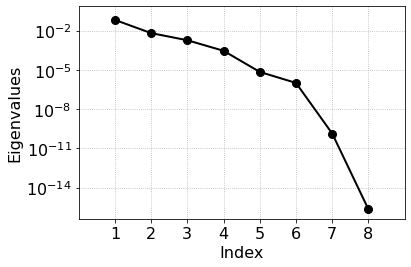

In [9]:
ss.plot_eigenvalues(figsize=(6, 4))

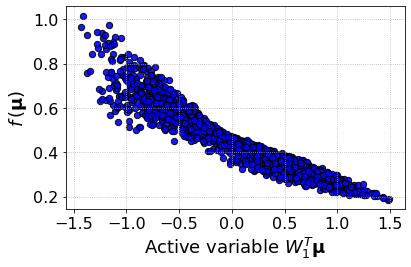

In [10]:
ss.plot_sufficient_summary(x_np, f, figsize=(6, 4))

In [12]:
orig_sens = as_sensitivity(ss, x_valid, example, nor)[0]
as_sens = as_sensitivity(ss, x_valid, example, nor)[1]

orig_sens_norm = np.empty(orig_sens.shape)
as_sens_norm = np.empty(as_sens.shape)

In [13]:
for i in range(orig_sens_norm.size):
    orig_sens_norm[i] = (orig_sens[i]/sum(orig_sens)) * 100

for i in range(as_sens_norm.size):
    as_sens_norm[i] = (as_sens[i]/sum(as_sens)) * 100

In [14]:
# Now NLL approach
nll = NonlinearLevelSet(n_layers=10,
                        active_dim=1, 
                        lr=0.01,
                        epochs=400,
                        dh=0.25,
                        optimizer=torch.optim.Adam)

In [15]:
x_torch = torch.as_tensor(x_np, dtype=torch.double)
df_torch = torch.as_tensor(df_np, dtype=torch.double)

In [16]:
nll.train(inputs=x_torch,
          gradients=df_torch,
          interactive=False)

epoch = 0, loss = 0.23541480617356564
epoch = 10, loss = 0.11764620205346807
epoch = 20, loss = 0.08267566077488912
epoch = 30, loss = 0.059839759454092874
epoch = 40, loss = 0.042360592962905036
epoch = 50, loss = 0.03369682866212335
epoch = 60, loss = 0.028552892897847706
epoch = 70, loss = 0.02493542047784834
epoch = 80, loss = 0.021653151000605053
epoch = 90, loss = 0.018947172756573195
epoch = 100, loss = 0.016771466375566098
epoch = 110, loss = 0.014980133446246461
epoch = 120, loss = 0.013479010378559309
epoch = 130, loss = 0.012241084943502336
epoch = 140, loss = 0.011221685511742244
epoch = 150, loss = 0.010323604584957362
epoch = 160, loss = 0.009487683009080282
epoch = 170, loss = 0.008701913559488947
epoch = 180, loss = 0.0080390594603139
epoch = 190, loss = 0.0074939545079528765
epoch = 200, loss = 0.00701235093052525
epoch = 210, loss = 0.006582237845504319
epoch = 220, loss = 0.006199350623366834
epoch = 230, loss = 0.0058587194764295105
epoch = 240, loss = 0.00563539045

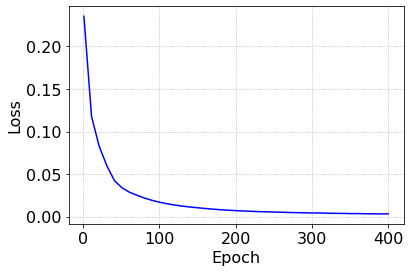

In [17]:
nll.plot_loss(figsize=(6, 4))

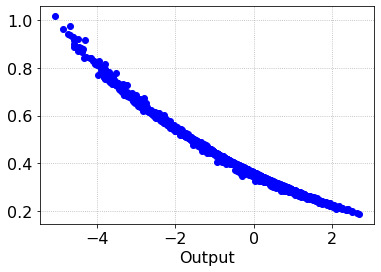

In [18]:
nll.plot_sufficient_summary(x_torch, f, figsize=(6, 4))

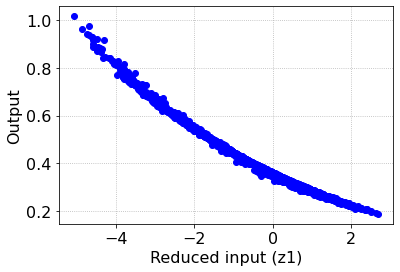

In [19]:
plot_sufficient_summary2(nll, x_torch, f, figsize=(6,4))

In [21]:
nll_sens = nll_sensitivity(nll, x_valid, example, nor)[1]

nll_sens_norm = np.empty(nll_sens.shape)

for i in range(nll_sens_norm.size):
    nll_sens_norm[i] = (nll_sens[i]/sum(nll_sens)) * 100

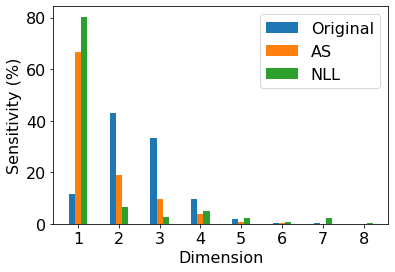

In [22]:
x_labels = [i for i in range(1, n_params+1)]
w = 0.15
pivot = np.arange(len(x_labels))
bar1 = [p - w for p in pivot]
bar2 = [p for p in pivot]
bar3 = [p + w for p in pivot]

plt.bar(bar1, orig_sens_norm, w, label="Original")
plt.bar(bar2, as_sens_norm, w, label="AS")
plt.bar(bar3, nll_sens_norm, w, label="NLL")


plt.xticks(pivot, x_labels) 
plt.xlabel("Dimension")
plt.ylabel("Sensitivity (%)")
plt.legend()

plt.show()

In [23]:
print(orig_sens_norm)
print(as_sens_norm)
print(nll_sens_norm)

[11.44161801 42.89338837 33.47400698  9.68055081  1.97984849  0.13993087
  0.39065648  0.        ]
[6.67733522e+01 1.91194533e+01 9.44170127e+00 3.82442858e+00
 6.06581335e-01 2.32162210e-01 2.32112824e-03 2.00589694e-11]
[80.35138095  6.4915634   2.5446674   5.05191284  2.40420812  0.60372433
  2.16012021  0.39242274]
